In [1]:
import os
import json
import pandas as pd
from helper import get_openai_api_key
from langgraph.graph import StateGraph, END, START
from typing import TypedDict, Optional, List, Dict, Any
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings
from IPython.display import Image

memory = MemorySaver()
openai_api_key = get_openai_api_key()

In [2]:
import chromadb
from chromadb import PersistentClient
from chromadb.config import Settings

# Ensure database directory exists
os.makedirs("database", exist_ok=True)

# Initialize ChromaDB client with reset enabled
chroma_client = chromadb.PersistentClient(
    path="database/products_db",  # Your persistence directory
    settings=Settings(allow_reset=True)  # Enable reset functionality
)

# Run this, if you want to reset the database
chroma_client.reset()
print("ChromaDB has been reset.")

processed_files_collection = chroma_client.get_or_create_collection("processed_files")

ChromaDB has been reset.


In [3]:
class AgentState(TypedDict):
    user_input: str
    file_paths: Optional[List[str]]
    file_processing: bool
    unprocessed_files: Optional[List[str]]
    extracted_data: Optional[List[dict]]
    embedding_status: Optional[str]
    search_result: Optional[List[dict]]
    final_answer: Optional[List[Dict[str, Any]]] 
    error: Optional[str]
    search_results_count: Optional[int]

In [4]:
def is_file_processed(file_name: str) -> bool:
    try:
        results = processed_files_collection.get(ids=[file_name], include=[])
        return len(results.get("ids", [])) > 0
    except Exception:
        return False

def check_file_processing_node(state: AgentState) -> dict:
    file_paths = state.get("file_paths", [])
    
    # If no files provided, skip processing entirely
    if not file_paths:
        print("📋 No files provided. Proceeding to search.")
        return {
            "file_processing": False,
            "unprocessed_files": []
        }
    
    unprocessed = []
    for path in file_paths:
        file_name = os.path.basename(path)
        if not is_file_processed(file_name):
            unprocessed.append(path)
    
    if unprocessed:
        print(f"🔍 Unprocessed files found: {unprocessed}")
        return {
            "file_processing": True,
            "unprocessed_files": unprocessed
        }
    
    print("✅ All files already processed. Skipping extraction.")
    return {
        "file_processing": False,
        "unprocessed_files": []
    }

In [5]:
def extract_products_node(state: AgentState) -> dict:
    # Only process if file_processing is True AND we have unprocessed files
    if not state.get("file_processing") or not state.get("unprocessed_files"):
        print("⏭️ Skipping extraction - no files to process")
        return {}
    
    file_paths = state.get("unprocessed_files", [])
    
    try:
        print(f"\n🔹 [extract_products_node] Processing Excel files: {file_paths}")
        all_data = []
        
        for path in file_paths:  # Use unprocessed_files, not file_paths
            df = pd.read_excel(path)
            df.columns = [col.strip() for col in df.columns if col.strip()]
            rows = df.to_dict(orient="records")
            all_data.append({"file": path, "rows": rows})
            
        # print("\n✅ [extract_products_node] Final Extracted Data:", all_data)    
        return {"extracted_data": all_data}
        
    except Exception as e:
        print(f"\n❌ [extract_products_node] Error: {e}")
        return {"error": f"Extraction failed: {str(e)}"}

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

def embed_products_node(state: AgentState) -> dict:
    
    # Only embed if we have extracted data to process
    if not state.get("file_processing") or not state.get("extracted_data"):
        print("⏭️ Skipping embedding - no data to embed")
        return {}
    
    try:
        print("🔗 [embed_products_node] Starting embedding process...")
        rows = []
        for group in state["extracted_data"]:
            rows.extend(group["rows"])
        
        documents = [json.dumps(row) for row in rows]
        vector_db = Chroma(
            client=chroma_client,
            collection_name="product_data",
            embedding_function=embedding_function
        )
        vector_db.add_texts(documents)
        
        # Mark each processed file as done
        for group in state["extracted_data"]:
            file_name = os.path.basename(group["file"])
            processed_files_collection.add(
                ids=[file_name],
                documents=["processed"],
                metadatas=[{"file_path": group["file"]}]
            )
        
        print("✅ [embed_products_node] Files embedded and marked as processed")
        return {"embedding_status": "done"}
        
    except Exception as e:
        print(f"❌ [embed_products_node] Error: {e}")
        return {"error": f"Embedding failed: {str(e)}"}

In [6]:
def search_products_node(state: AgentState) -> dict:

    try:

        # Get k from state, default to 10 if not provided
        k = state.get("search_results_count", 10)
        
        vector_db = Chroma(
            client=chroma_client,
            collection_name="product_data",
            embedding_function=embedding_function
        )
        results = vector_db.similarity_search(state["user_input"], k=k)
        matched_products = [json.loads(doc.page_content) for doc in results]
        print("MATCHED PRODUCTS:")
        print(matched_products)
        return {"search_result": matched_products}
    except Exception as e:
        return {"error": f"Search failed: {str(e)}"}


# Define structured output schema
class ProductResponse(BaseModel):
    products: List[Dict[str, Any]] = Field(
        description="Filtered product list matching the user query"
    )

@tool(args_schema=ProductResponse)
def return_relevant_products(products: List[Dict[str, Any]]) -> List[Dict[str, Any]]:
    """Return relevant products extracted from the structured product data."""
    return products


def answer_node(state: AgentState) -> dict:
    from langchain_core.messages import SystemMessage, HumanMessage
    from langchain_openai import ChatOpenAI

    model = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools([return_relevant_products])

    messages = [
        SystemMessage(content="""
            You are a helpful assistant that receives:
            - A natural language user query
            - A list of product data entries as JSON dictionaries
            
            Each product entry may contain different fields, as the structure is extracted from spreadsheets with varying formats. Your job is to:
            - Carefully examine all available fields in each product
            - Match the user's intent using relevant fields (e.g. name, description, group, category, price, etc.)
            - Select only products that clearly satisfy the user’s query
            - Do NOT make up field values that do not exist
            
            You MUST respond by calling the `return_relevant_products` tool with the list of relevant product dictionaries. 
            Return an empty list if nothing clearly matches, but do not ignore obvious matches.
            
            Be strict and explicit in your reasoning: even if fields are not consistently named across rows, try your best to interpret them accurately from their context.
            """),
        HumanMessage(content=f"User query: {state['user_input']}\n\nProduct data: {json.dumps(state['search_result'], indent=2)}")
    ]

    response = model.invoke(messages)
    # print("\n📥 Final Answer (Tool Call):\n", response)

    try:
        tool_call = response.tool_calls[0]
        args = tool_call['args'] if isinstance(tool_call['args'], dict) else {}
        return {"final_answer": args.get("products", [])}
    except Exception as e:
        return {"final_answer": [{"error": f"Failed to parse tool call: {str(e)}", "raw": str(response)}]}



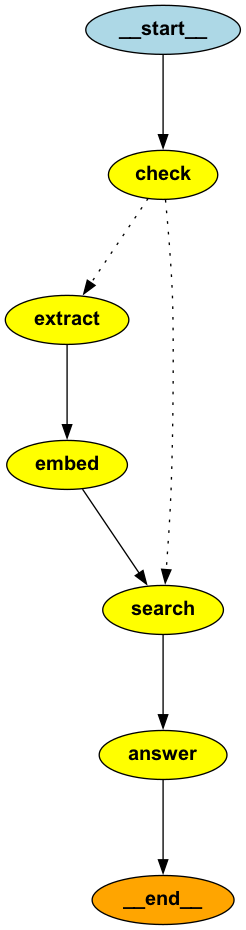

In [7]:
def next_step(state: AgentState) -> str:
    if state.get("file_processing"):
        return "extract"
    else:
        return "search"

def build_graph():
    builder = StateGraph(AgentState)

    builder.add_node("check", check_file_processing_node)
    builder.add_node("extract", extract_products_node)
    builder.add_node("embed", embed_products_node)
    builder.add_node("search", search_products_node)
    builder.add_node("answer", answer_node)

    # Routing from START to check node
    builder.add_edge(START, "check")

    # Conditional routing based on the check whether file processing is needed. 
    builder.add_conditional_edges(
        "check",
        lambda state: "extract" if state.get("file_processing") else "search",
        {"extract": "extract", "search": "search"}
    )

    # Extraction path
    builder.add_edge("extract", "embed")
    builder.add_edge("embed", "search")

    # Common final path
    builder.add_edge("search", "answer")
    builder.add_edge("answer", END)


    return builder

builder = build_graph()
workflow = builder.compile(checkpointer=MemorySaver())
Image(workflow.get_graph().draw_png())
# workflow.get_graph().draw_png("workflow_graph.png")  # Saves to a file    

In [9]:
def run_agent(user_input: str, file_processing: bool = True, file_paths: Optional[List[str]] = None, search_results_count: int = 10) -> AgentState:
    global workflow

    state: AgentState = {
        "user_input": user_input,
        "file_paths": file_paths or [],
        "file_processing": False,
        "unprocessed_files": None,
        "extracted_data": None,
        "embedding_status": None,
        "search_result": None,
        "final_answer": None,
        "error": None,
        "search_results_count": search_results_count
    }

    thread = {"configurable": {"thread_id": "1"}}
    return workflow.invoke(state, thread)


state = run_agent(
    user_input="Show me some vegetable planter options.",
    file_paths=["Gardening_Products_1.xlsx","Gardening_Products_2.xlsx"], 
    search_results_count=15
)


# USE THIS - to get just the answer to your question!
# Converts the full search_result JSON to DataFrame with all unique keys as columns
if state.get("final_answer"):
    df = pd.DataFrame(state["final_answer"])
    display(df)
else:
    print("No search results to display.")

# USE THIS - to print print the full state for inspection! 
# print(json.dumps(state, indent=2))

# if state.get("final_answer") and isinstance(state["final_answer"], list):
#     df = pd.DataFrame(state["final_answer"])
#     display(df)
# else:
#     print(" No valid tabular data to display.")


✅ All files already processed. Skipping extraction.
MATCHED PRODUCTS:
[{'Manufacturer Code': 'GR-1061', 'Brand': 'Miller, Fields and Hoffman', 'Group': 'Planters', 'Description': 'Large raised planter ideal for vegetables and herbs. Includes liner.', 'Catalog Price (excl. VAT)': 383.09, 'Discount %': 15, 'Delivery Price': 146.26, 'Weight': 5.31, 'Length': 78.2, 'Material': 'Cedar Wood'}, {'Manufacturer Code': 'GR-1190', 'Brand': 'Hall-Meyer', 'Group': 'Planters', 'Description': 'Large raised planter ideal for vegetables and herbs. Includes liner.', 'Catalog Price (excl. VAT)': 324.71, 'Discount %': 0, 'Delivery Price': 232.36, 'Weight': 3.25, 'Length': 38.2, 'Material': 'Cedar Wood'}, {'Manufacturer Code': 'GR-1048', 'Brand': 'Thompson, Stafford and Burgess', 'Group': 'Planters', 'Description': 'Large raised planter ideal for vegetables and herbs. Includes liner.', 'Catalog Price (excl. VAT)': 161.45, 'Discount %': 15, 'Delivery Price': 285.67, 'Weight': 1.21, 'Length': 14.4, 'Material

,Manufacturer Code,Brand,Group,Description,Catalog Price (excl. VAT),Discount %,Delivery Price,Weight,Length,Material
0,GR-1061,"Miller, Fields and Hoffman",Planters,Large raised planter ideal for vegetables and ...,383.09,15,146.26,5.31,78.2,Cedar Wood
1,GR-1190,Hall-Meyer,Planters,Large raised planter ideal for vegetables and ...,324.71,0,232.36,3.25,38.2,Cedar Wood
2,GR-1048,"Thompson, Stafford and Burgess",Planters,Large raised planter ideal for vegetables and ...,161.45,15,285.67,1.21,14.4,Cedar Wood
3,GR-1058,Brown Inc,Planters,Large raised planter ideal for vegetables and ...,366.96,0,49.04,7.40,55.9,Cedar Wood
4,GR-1012,Smith-Rogers,Planters,Large raised planter ideal for vegetables and ...,348.65,20,215.93,1.36,67.7,Cedar Wood
5,GR-1011,"Rodgers, Bradley and Anderson",Planters,Large raised planter ideal for vegetables and ...,121.51,20,280.99,7.59,87.6,Cedar Wood
6,GR-1135,Woods-Garza,Planters,Large raised planter ideal for vegetables and ...,199.68,5,62.49,3.32,89.6,Cedar Wood
7,GR-1121,"Hicks, Salas and Miller",Planters,Large raised planter ideal for vegetables and ...,56.20,20,281.47,7.26,71.0,Cedar Wood
8,GR-1160,"Fields, Wallace and Butler",Planters,Large raised planter ideal for vegetables and ...,77.78,5,250.69,2.58,86.8,Cedar Wood
9,GR-1136,"Brown, Oliver and Vasquez",Planters,Large raised planter ideal for vegetables and ...,148.37,10,133.27,1.71,21.2,Cedar Wood
